In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


%matplotlib inline	

## Pre-processing

In [4]:
columns = ['arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8', 'attack']

df = pd.read_csv("post-attack-labeled/DoS-attacks/DoS-1.csv", sep=",", index_col=None)

# Function to split each value into 8 bytes
def split_bytes(value):
    bytes_list = [value[i:i+2] for i in range(0, len(value), 2)]
    return bytes_list

# Apply the function to create new columns
df_bytes = df['data_field'].apply(split_bytes).apply(pd.Series)

# Rename columns
df_bytes.columns = [f'byte_{i+1}' for i in range(df_bytes.shape[1])]

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, df_bytes], axis=1)


# Drop data_field
df = df.drop(["data_field"], axis= 1)

# Set new order to columns with attack label last
df = df[columns]

# Convert from hex to decimal
for i in columns:
    if i == 'attack':
        continue
    df[i] = df[i].astype(str).dropna().apply(lambda x: float.fromhex(x))

# Replace NaN values with 0
df.fillna(0, inplace=True)

df


,arbitration_id,byte_1,byte_2,byte_3,byte_4,byte_5,byte_6,byte_7,byte_8,attack
0,338.0,249.0,164.0,0.0,0.0,0.0,0.0,16.0,140.0,0
1,356.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0
2,328.0,11.0,25.0,0.0,128.0,65.0,0.0,17.0,5.0,0
3,329.0,124.0,1.0,63.0,121.0,169.0,20.0,0.0,0.0,0
4,342.0,1.0,128.0,0.0,0.0,0.0,0.0,0.0,15.0,0
...,...,...,...,...,...,...,...,...,...,...
643802,321.0,124.0,42.0,222.0,43.0,160.0,5.0,0.0,2.0,0
643803,324.0,0.0,0.0,109.0,52.0,47.0,168.0,0.0,64.0,0
643804,328.0,11.0,25.0,157.0,133.0,65.0,0.0,102.0,5.0,0
643805,329.0,26.0,12.0,63.0,47.0,170.0,32.0,0.0,0.0,0


In [5]:
df['attack'].value_counts()

attack
0    631716
1     12091
Name: count, dtype: int64

In [6]:
train_cols = ['arbitration_id', 'byte_1', 'byte_2', 'byte_3', 'byte_4', 'byte_5', 'byte_6', 'byte_7', 'byte_8']

# Scale

In [7]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder 
    else:
        if col == 'attack' or col == 'timestamp':
            continue 
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        encoder_map[col] = scaler 


# Train-test split

In [8]:
labels = df['attack']
# Conduct a train-test split    
x_train, x_test, y_train, y_test = train_test_split(df[train_cols].values, labels.values, test_size = 0.15, random_state = 42)

In [9]:
# Additional split of training dataset to create validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(437788, 9)
y_train:(437788,)

x_val:(109447, 9)
y_val:(109447,)

x_test:(96572, 9)
y_test:(96572,)


# Separate normal data from anomalies

In [11]:
# Split a set into 80% only normal data, and 20% normal data + any anomalies in set
def split_by_class(x, y):
    # Separate into normal, anomaly
    x_normal = x[y == 0]
    x_anom = x[y==1]
    
    y_normal = y[y==0]
    y_anom = y[y==1]
    
    # Split normal into 80-20 split, one for pure training and other for eval
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_normal, y_normal, test_size=0.2, random_state=42)
    
    # Combine the eval set with the anomalies to test outlier detection
    x_train_test = np.concatenate((x_train_test, x_anom))
    y_train_test = np.concatenate((y_train_test, y_anom))
    
    # Shuffle the eval set
    random_indices = np.random.choice(list(range(len(x_train_test))), size=len(x_train_test), replace=False)
    x_train_test = x_train_test[random_indices]
    y_train_test = y_train_test[random_indices]
    
    return x_train_train, x_train_test, y_train_train, y_train_test

In [12]:
### Train on normal data only. The _test splits have normal and anomaly data both
x_train_train, x_train_test, y_train_train, y_train_test = split_by_class(x_train, y_train)

In [13]:
x_train_test

array([[-0.25331683, -0.40751601, -0.55793623, ..., -0.21321254,
        -0.01766559,  1.93037894],
       [-0.20581752, -0.67856618, -0.6059766 , ..., -0.60480463,
        -0.48203405, -0.56047905],
       [ 2.94694946, -0.67856618, -0.6059766 , ..., -0.26428977,
         0.26427241,  1.91481108],
       ...,
       [ 1.36462855, -0.67856618,  0.06658859, ..., -0.60480463,
        -0.48203405, -0.56047905],
       [ 1.3854095 , -0.63142702, -0.6059766 , ..., -0.60480463,
        -0.48203405, -0.56047905],
       [-0.57690591, -0.67856618, -0.52590932, ..., -0.00890362,
         1.55787027, -0.56047905]])

In [14]:
print(f"x_train_train: {x_train_train.shape}")
print(f"y_train_train: {y_train_train.shape}")   
print(f"x_train_test: {x_train_test.shape}") 
print(f"y_train_test: {y_train_test.shape}") 

x_train_train: (343589, 9)
y_train_train: (343589,)
x_train_test: (94199, 9)
y_train_test: (94199,)


## One-Class SVM

In [15]:
# estimate proportion of anomalies
(y_test==1).sum() / len(y_test)

0.01822474423228265

In [16]:
svm = OneClassSVM(nu=0.0065, gamma=0.05)
svm.fit(x_train_train[:])

OneClassSVM(gamma=0.05, nu=0.0065)

In [17]:
preds = svm.predict(x_train_test)
# -1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.
preds = (preds < 0).astype(int) 
preds

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
pre = precision_score(y_train_test, preds )
rec = recall_score(y_train_test, preds)
f1 = f1_score(y_train_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")


Precision: 0.9310228802153432
Recall: 1.0
F1-Measure: 0.9642794912005576


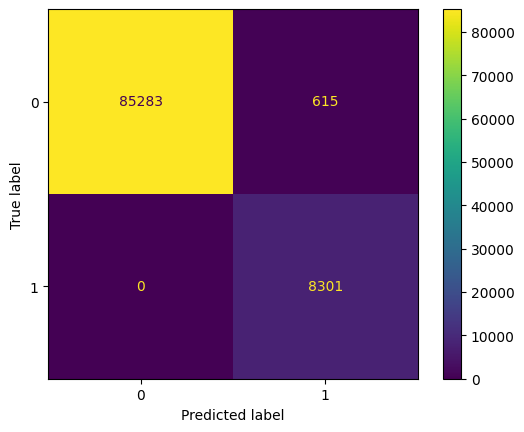

In [19]:
ConfusionMatrixDisplay(confusion_matrix(y_train_test, preds)).plot()

# Hyperparameter testing

### Gamma

In [20]:
def experiment(svm, x_train, y_train, x_test, y_test):
    
    # Fit on the training data, predict on the test
    svm.fit(x_train)
    
    preds = svm.predict(x_test)
    
    # Predictions are either -1 or 1
    preds = (preds < 0).astype(int)
    
    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    
    return {'precision': pre, 'recall': rec, 'f1': f1}

In [32]:
selected_nu = 0.00015

In [33]:
validation_results = {}
gamma = [0.005, 0.05, 0.5]
for g in gamma:

    svm = OneClassSVM(nu=selected_nu, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res
 
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.005, 0.973621103117506),
 (0.05, 0.6295549697627539),
 (0.5, 0.2023928215353938)]

In [34]:
validation_results = {}
gamma = [1, 5, 10, 15, 20, 100, 150, 200]
for g in gamma:
    g = g / 1000.0

    svm = OneClassSVM(nu=selected_nu, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.005, 0.973621103117506),
 (0.01, 0.9675881792183031),
 (0.015, 0.9593572778827977),
 (0.02, 0.9577730596838877),
 (0.1, 0.5011108368304122),
 (0.15, 0.8265472312703583),
 (0.2, 0.5403247271759383)]

In [35]:
validation_results = {}
gamma = [0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018]
for g in gamma:

    svm = OneClassSVM(nu=selected_nu, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.011, 0.9666666666666667),
 (0.012, 0.965976683321437),
 (0.013, 0.9604920747575112),
 (0.014, 0.9639126305792972),
 (0.015, 0.9593572778827977),
 (0.016, 0.9584513692162417),
 (0.017, 0.9595840226896715),
 (0.018, 0.963226571767497)]

In [24]:
# If included timestamp:
validation_results = {}
gamma = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
for g in gamma:

    svm = OneClassSVM(nu=selected_nu, gamma=g)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.05, 0.5792552432586674),
 (0.1, 0.6402775587446775),
 (0.15, 0.4730831973898858),
 (0.2, 0.4598482274323253),
 (0.25, 0.5309271609781614),
 (0.3, 0.4187725631768953),
 (0.35, 0.4348291742529721),
 (0.4, 0.38505311077389986)]

### nu

In [36]:
# 0.14 works best without timestamp
selected_gamma = 0.005

In [37]:

validation_results = {}
nu = range(1, 10)
for n in nu:
    n = n / 1000.0

    svm = OneClassSVM(nu=n, gamma= selected_gamma)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.0),
 (0.002, 0.9301260022909508),
 (0.003, 0.9026233881725211),
 (0.004, 0.8847243408149924),
 (0.005, 0.8706841089427407),
 (0.006, 0.8504398826979472),
 (0.007, 0.0),
 (0.008, 0.0),
 (0.009, 0.0)]

In [38]:
validation_results = {}
nu = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 15]
for n in nu:
    n = n / 100000.0

    svm = OneClassSVM(nu=n, gamma=selected_gamma)
    
    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(1e-05, 0.9359151682803135),
 (2e-05, 0.9722222222222222),
 (3e-05, 0.9643705463182898),
 (4e-05, 0.9708273553323769),
 (5e-05, 0.9757269887046383),
 (6e-05, 0.9731543624161074),
 (7e-05, 0.9747899159663865),
 (8e-05, 0.9731543624161074),
 (9e-05, 0.9752582272399711),
 (0.0001, 0.9719894661240125),
 (0.00011, 0.973621103117506),
 (0.00012, 0.970595266555104),
 (0.00013, 0.9745559289486317),
 (0.00015, 0.973621103117506)]

## Re-train model


In [39]:
svm = OneClassSVM(nu=0.00005, gamma=0.005)
svm.fit(x_train_train[:])

OneClassSVM(gamma=0.005, nu=5e-05)

In [40]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)

In [41]:
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

Precision: 0.9966024915062288
Recall: 1.0
F1-Measure: 0.998298355076574


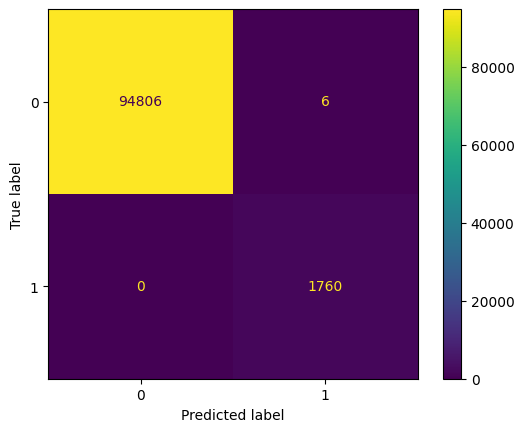

In [42]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()